In [ ]:
!pip install --quiet -U optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
import yfinance as yf

# Descargar datos
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
tickers = ['BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
horizon = 4

In [ ]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape as smape_cv, mape as mape_cv
import logging
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # Definir los hiperparámetros a optimizar con rangos ajustados
    patch_len = trial.suggest_int('patch_len', 6, 12)
    stride = trial.suggest_int('stride', 6, 12)
    n_heads = trial.suggest_int('n_heads', 8, 12)
    input_size = trial.suggest_int('input_size', 1, 3)

    # Definir un rango de hidden_size que sea múltiplo de n_heads
    min_hidden_size = 32  # Valor mínimo deseado
    max_hidden_size = 256  # Valor máximo deseado

    # Asegurarse de que min_hidden_size sea un múltiplo de n_heads
    if min_hidden_size % n_heads != 0:
        min_hidden_size += n_heads - (min_hidden_size % n_heads)

    # Asegurarse de que max_hidden_size sea un múltiplo de n_heads
    if max_hidden_size % n_heads != 0:
        max_hidden_size -= max_hidden_size % n_heads

    # Calcular la cantidad de múltiplos de n_heads en el rango
    num_options = (max_hidden_size - min_hidden_size) // n_heads + 1

    # Sugerir hidden_size como un múltiplo de n_heads
    hidden_size = trial.suggest_int('hidden_size', min_hidden_size, max_hidden_size)

    # Asegurar que hidden_size sea un múltiplo de n_heads
    if hidden_size % n_heads != 0:
        hidden_size = (hidden_size // n_heads) * n_heads  # Asegurarse de que sea un múltiplo

    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    fc_dropout = trial.suggest_float('fc_dropout', 0.1, 0.4)
    head_dropout = trial.suggest_float('head_dropout', 0.1, 0.4)
    attn_dropout = trial.suggest_float('attn_dropout', 0.1, 0.4)

    activation = trial.suggest_categorical('activation', ['relu', 'gelu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    windows_batch_size = trial.suggest_int('windows_batch_size', 256, 512)
    inference_windows_batch_size = trial.suggest_int('inference_windows_batch_size', 256, 512)

    model = PatchTST(
        h=horizon,
        input_size=input_size,
        patch_len=patch_len,
        stride=stride,
        hidden_size=hidden_size,
        n_heads=n_heads,
        dropout=dropout,
        fc_dropout=fc_dropout,
        head_dropout=head_dropout,
        attn_dropout=attn_dropout,
        activation=activation,
        loss=SMAPE(),
        learning_rate=learning_rate,
        max_steps=500,
        val_check_steps=50,
        batch_size=batch_size,
        start_padding_enabled=True,
        enable_progress_bar=False
    )

    # Crear y ajustar el modelo
    nf = NeuralForecast(
        models=[model],
        freq='M',
    )

    cv_df = nf.cross_validation(Y_df, n_windows = 3, step_size = horizon)
    cv_df = cv_df.reset_index()

    evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape_cv, mape_cv])

    smape = evaluation_df[evaluation_df['metric'] == 'smape']['PatchTST']
    mape = evaluation_df[evaluation_df['metric'] == 'mape']['PatchTST']

    trial.set_user_attr('mape', mape)

    return smape

# Crear el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
mape = best_trial.user_attrs['mape']

print("Best hyperparameters:", study.best_params)
print("Best SMAPE:", study.best_value)
print(f'Best MAPE: {mape}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Best hyperparameters: {'patch_len': 7, 'stride': 10, 'n_heads': 11, 'input_size': 3, 'hidden_size': 165, 'dropout': 0.11998555198561675, 'fc_dropout': 0.24435287576471998, 'head_dropout': 0.31137412591288804, 'attn_dropout': 0.36425563859502486, 'activation': 'relu', 'learning_rate': 0.0016714620089442066, 'batch_size': 28, 'windows_batch_size': 337, 'inference_windows_batch_size': 421}
Best SMAPE: 0.13831907025598608
Best MAPE: 1    0.233532
Name: PatchTST, dtype: float64


In [ ]:
model_PatchTST = PatchTST(h = horizon, **study.best_params)
nf = NeuralForecast(models=[model_PatchTST],freq='MS')

prediction_length = int(len(Y_df)) - horizon
Y_df_real = Y_df[:prediction_length]
Y_df_test = Y_df[prediction_length:]

nf.fit(Y_df_real)
forecast_df = nf.predict(Y_df_real)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

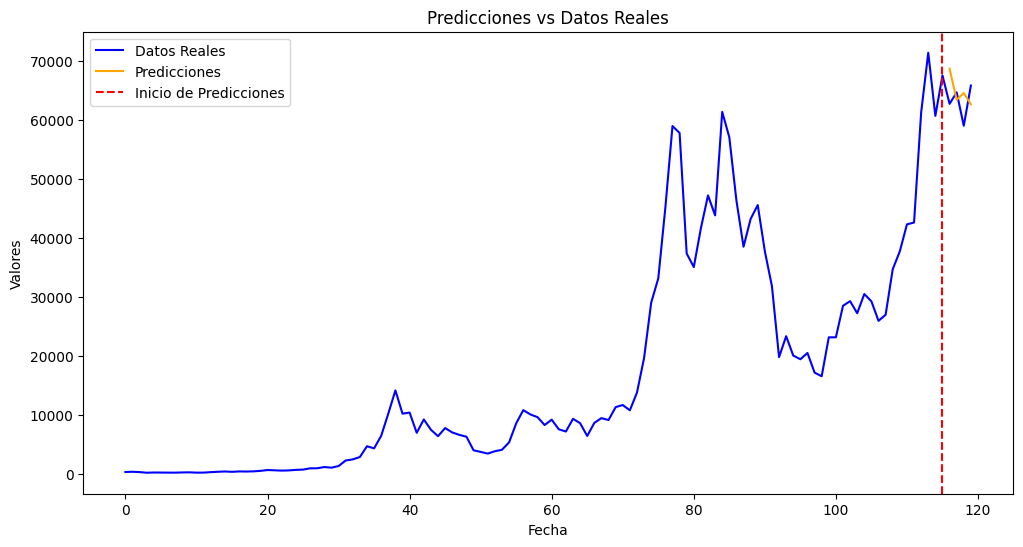

In [ ]:
import matplotlib.pyplot as plt

# Convertir a formato adecuado para graficar
# Asegúrate de que `forecast_df` tenga la columna 'y' con las predicciones
forecast_series = forecast_df['PatchTST']
real_series = Y_df_test['y']

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(Y_df.index, Y_df['y'], label='Datos Reales', color='blue')
plt.plot(Y_df.index[prediction_length:], forecast_series, label='Predicciones', color='orange')
plt.axvline(x=Y_df.index[prediction_length - 1], color='red', linestyle='--', label='Inicio de Predicciones')
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()